This notebook describes a procedure to build a perturbed parameter ensemble constrained with the RCMIP phase 2 (RCMIP2, https://www.rcmip.org/) protocol. The model components and ensemble run results are described in Tsutsui (2021).

Tsutsui, J.: Minimal CMIP Emulator (MCE v1.2): A new simplified method for probabilistic climate projections, Geosci. Model Dev. Discuss. [preprint], https://doi.org/10.5194/gmd-2021-79, in review, 2021.

In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
from io import StringIO
from mce.util.stat import StatModel, SamplingMH
from mce.util.plot import wrap_plotspace
from scipy.stats import gaussian_kde
import seaborn as sns

## Read indicator data

Here, indicators are a set of specific variables to characterize climate and carbon cycle response to changes in CO2 and other forcing factors. We use results from MCE's large-member ensemble experiments perturbed with a set of proposed parameters that broadly encompasses a CMIP multi-model ensemble. Currently, the data file is out of this repository, but a similar procedure is described in [`t_genparms.ipynb`](./t_genparms.ipynb).

In [2]:
ncf_calib = Dataset('../untracked/indicators_calib.nc')
ncf_calib.dimensions

{'ensemble_member': <class 'netCDF4._netCDF4.Dimension'>: name = 'ensemble_member', size = 150000}

### List of indicators

Naming of the indicators follows a convention of an MCE variable name connected with time and scenario attributes using double underscores. The scenarios are a 1%-per-year increase of the atmospheric CO2 concentration (`1pctCO2`), initialized with a 1850 concentration, and two historical concentration changes, starting from 1750 and 1850 (`historical_1750` and `historical_1850`). The 1750 historical is intended to be used for carbon cycle indicators while the 1850 historical for thermal indicators. Forcing is defined as values relative to 1750 levels in any cases.

In [3]:
for vn in ncf_calib.variables:
    if vn in ncf_calib.dimensions:
        continue
    v = ncf_calib.variables[vn]
    print(f'{vn}: {v.long_name} ({v.units})')

tcr__y70__1pctCO2: Transient temperature response in 70th year (degC)
tcre__y70__1pctCO2: Transient temperature response to cumulative CO2 emissions in 70th year (degC/1000 GtC)
tcre__y140__1pctCO2: Transient temperature response to cumulative CO2 emissions in 140th year (degC/1000 GtC)
coct__y70__1pctCO2: Accumulated carbon over ocean in 70th year (GtC)
cbst__y70__1pctCO2: Accumulated carbon over land in 70th year (GtC)
ctot__y70__1pctCO2: Implied cumulative CO2 emissions in 70th year (GtC)
coct__y140__1pctCO2: Accumulated carbon over ocean in 140th year (GtC)
cbst__y140__1pctCO2: Accumulated carbon over land in 140th year (GtC)
ctot__y140__1pctCO2: Implied cumulative CO2 emissions in 140th year (GtC)
tas__2000-2019__historical_1750: Surface air temperature change in 2000-2019 (degC)
tas__1961-1990__historical_1750: Surface air temperature change in 1961-1990 (degC)
thc__2018__historical_1750: Total heat content change in 2018 (ZJ)
thc__1971__historical_1750: Total heat content change

### Read perturbed parameter data

Transient climate response refers to the model's derived parameter `climate_tcr`, instead of the one diagnosed from `1pctCO2` experiment output (`tcr__y70__1pctCO2`).

In [4]:
ncf_parms = Dataset('../untracked/parms_perturbed.nc')
ncf_parms.dimensions

{'ensemble_member': <class 'netCDF4._netCDF4.Dimension'>: name = 'ensemble_member', size = 150000}

In [5]:
vn = 'climate__tcr'
v = ncf_parms.variables[vn]
print(f'{vn}: {v.long_name} ({v.units})')

climate__tcr: Transient climate response (degC)


## Constrain using selected indicators

Although a number of indicators are prepared to consider the RCMIP2 constraints given by "proxy" assessed ranges, a very limited number of those are used for simplicity in the following procedure. This is mainly due to possible inconsistency among the constraints, which makes it difficult to build an ensemble that satisfactorily matches all the constraints. Here, a "proxy" assessment means that it is based on recent literature instead of using a formal assessment in the IPCC sixth assessment report, which had not yet been published during the RCMIP2 project.

In the following, an ordered series for a subset of the indicators from the perturbed-parameter ensemble experiments is sequentially constrained by applying an acceptance/rejection algorithm. This process is a kind of Bayesian updating from a prior probability distribution to a posterior and here uses a Metropolis-Hastings (MH) independence sampler.

Although the MH sampler is supposed to generate a perturbed series that has a target distribution, the sequential updating demonstrated below does not satisfy the detailed balance required for such sampling as in the Markov chain Monte Carlo (MCMC) approach, resulting in some deviations from the assumed target. The current procedure has been established to deal with anyhow the RCMIP2 constraints, and needs to be improved using fully-consistent assessed ranges.

In [6]:
rv_indicators = {}
obj_stat = StatModel()

### CMIP-consistent series

First, a CMIP-consistent series is created from the original series with a constraint for `cbst|2x` indicator (accumulated land carbon at doubling CO2 along the 1%-per-year pathway). The original series is designed to encompass a variety of CMIP models, and this additional constraint is intended to further improve distribution similarity in terms of carbon cycle behavior. Constraining on the land carbon can also affect other indicators through a trade-off relationship between ocean and land carbon uptake.

This land carbon constraint is based on CMIP Earth system model data, adopted from Arora et al. (2020, https://doi.org/10.5194/bg-17-4173-2020) Figure 4 and Figure A2.

In [7]:
text = """#
# coct: Accumulated carbon over ocean (GtC)
# cbst: Accumulated carbon over land (GtC)
# ctot: Implied cumulative CO2 emissions (GtC)
# 2x/4x: 70th/140th year of a 1pctCO2 experiment
#
model          mip     coct|2x  cbst|2x  ctot|2x  coct|4x  cbst|4x  ctot|4x
ACCESS-ESM1-5  cmip6    276.     188.     1064.    662.     215.     2693.
UKESM1-0-LL    cmip6    229.     224.     1054.    554.     408.     2779.
IPSL-CM6A-LR   cmip6    229.     283.     1107.    579.     477.     2856.
GFDL-ESM4      cmip6    261.     229.     1066.    645.     499.     2922.
MPI-ESM1-2-LR  cmip6    229.     304.     1127.    575.     586.     2961.
CESM2          cmip6    229.     248.     1073.    551.     656.     3010.
MIROC-ES2L     cmip6    224.     315.     1135.    546.     701.     3049.
NorESM2-LM     cmip6    237.     244.     1075.    599.     652.     3050.
CNRM-ESM2-1    cmip6    224.     305.     1124.    547.     715.     3063.
BCC-CSM2-MR    cmip6    288.     406.     1291.    706.     875.     3390.
CanESM5        cmip6    234.     385.     1214.    562.     1204.    3566.
MIROC-ESM      cmip5    238.     151.     985.     580.     149.     2532.
CESM1-BGC      cmip5    232.     62.      893.     575.     176.     2563.
NorESM1-ME     cmip5    266.     69.      934.     667.     172.     2652.
CanESM2        cmip5    224.     183.     1006.    533.     494.     2839.
HadGEM2-ES     cmip5    232.     350.     1181.    587.     768.     3169.
BCC-CSM1.1     cmip5    268.     381.     1248.    647.     716.     3176.
IPSL-CM5A-LR   cmip5    264.     381.     1240.    670.     741.     3214.
MPI-ESM-LR     cmip5    256.     403.     1258.    632.     825.     3270.
"""
df_parms_cmip_esm = pd.read_table(StringIO(text), comment='#', delim_whitespace=True)
df_parms_cmip_esm

,model,mip,coct|2x,cbst|2x,ctot|2x,coct|4x,cbst|4x,ctot|4x
0,ACCESS-ESM1-5,cmip6,276.0,188.0,1064.0,662.0,215.0,2693.0
1,UKESM1-0-LL,cmip6,229.0,224.0,1054.0,554.0,408.0,2779.0
2,IPSL-CM6A-LR,cmip6,229.0,283.0,1107.0,579.0,477.0,2856.0
3,GFDL-ESM4,cmip6,261.0,229.0,1066.0,645.0,499.0,2922.0
4,MPI-ESM1-2-LR,cmip6,229.0,304.0,1127.0,575.0,586.0,2961.0
5,CESM2,cmip6,229.0,248.0,1073.0,551.0,656.0,3010.0
6,MIROC-ES2L,cmip6,224.0,315.0,1135.0,546.0,701.0,3049.0
7,NorESM2-LM,cmip6,237.0,244.0,1075.0,599.0,652.0,3050.0
8,CNRM-ESM2-1,cmip6,224.0,305.0,1124.0,547.0,715.0,3063.0
9,BCC-CSM2-MR,cmip6,288.0,406.0,1291.0,706.0,875.0,3390.0


A skewed normal distribution is fitted to the CMIP `cbst|2x` distribution and used for a target probability density for the MH sampler.

In [8]:
name = 'cbst|2x'
constraints = {
    'very_likely__lower': df_parms_cmip_esm[name].quantile(0.05),
    'central': df_parms_cmip_esm[name].mean(), # consider mean value as median
    'very_likely__upper': df_parms_cmip_esm[name].quantile(0.95),
}
rv = obj_stat.get_rv('skewnorm', constraints, a=0., loc=270., scale=50.)
print(name, rv.args, rv.kwds)
rv_indicators[name] = rv

cbst|2x (-2.761983351435631,) {'loc': 373.328278554515, 'scale': 155.62953259861692}


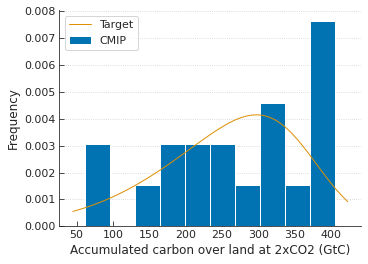

In [9]:
p1 = wrap_plotspace()
ax = p1.figure.axes[0]
p1.despine(ax)
df_parms_cmip_esm['cbst|2x'].plot(kind='hist', density=True, label='CMIP')
xlim = ax.get_xlim()
x = np.linspace(*xlim)
ax.plot(x, rv.pdf(x), label='Target')
ax.legend()
ax.set_xlabel('Accumulated carbon over land at 2xCO2 (GtC)')
ax.grid(axis='y')

In [10]:
obj_mh = SamplingMH(
    pd.Series(ncf_calib.variables['cbst__y70__1pctCO2'][:]),
    rv.pdf,
)
index1, index1a = obj_mh.sampling()
print('acceptance rate', len(index1a)/len(index1))

acceptance rate 0.8355866666666667


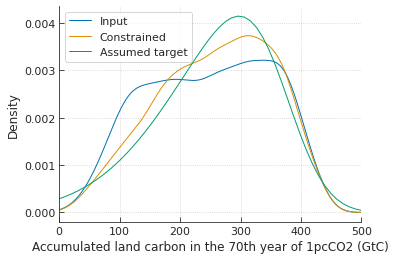

In [11]:
d1 = pd.Series(ncf_calib.variables['cbst__y70__1pctCO2'][:])
xlim = (0., 500.)
p1 = wrap_plotspace()
ax = p1.figure.axes[0]
p1.despine(ax)
d1.loc[:].iloc[:2000].plot(ax=ax, kind='kde', label='Input')
d1.loc[index1a].iloc[:2000].plot(ax=ax, kind='kde', label='Constrained')
x = np.linspace(*xlim)
ax.plot(x, rv_indicators['cbst|2x'].pdf(x), label='Assumed target')
ax.legend()
ax.set_xlim(*xlim)
ax.set_xlabel('Accumulated land carbon in the 70th year of 1pcCO2 (GtC)')
ax.grid()

Note: The series including not updated values (indexed with `index1`) satisfies the detailed balance required for the MCMC approach, but the series including updated values only (indexed with `index1a`) is adopted here for consistency with the subsequent procedure.

### RCMIP2-constrained series

A new class is defined to manipulate the RCMIP2 assessed ranges. The data file is available at the project's web site (https://www.rcmip.org/).

In [12]:
class ReadCsv:
    def __init__(self, infile):
        self.df = pd.read_csv(infile)
        # Define short names for selected RCMIP indicator names
        # For carbon cycle indicators, the current approach refers to Arora et al. (2020)
        self.map_names = {
            'gmst change':
            'Surface Air Ocean Blended Temperature Change World ssp245 2000-2019',
            'ecs': 'Equilibrium Climate Sensitivity',
            'tcr': 'Transient Climate Response',
            'tcre': 'Transient Climate Response to Emissions',
            'erf|CH4': 'Effective Radiative Forcing|Anthropogenic|CH4 World historical-1750',
            'erf|N2O': 'Effective Radiative Forcing|Anthropogenic|N2O World historical-1750',
            'erf|Montreal Gases':
            'Effective Radiative Forcing|Anthropogenic|Montreal Gases World historical-1750',
            'erf|F-Gases':
            'Effective Radiative Forcing|Anthropogenic|F-Gases World historical-1750',
            'erf|CO2': 'Effective Radiative Forcing|Anthropogenic|CO2 World historical-1750',
            'erf|Aerosols':
            'Effective Radiative Forcing|Anthropogenic|Aerosols World historical-1750',
            'erf|O3 Trop':
            'Radiative Forcing|Anthropogenic|Tropospheric Ozone World historical-1750',
            'erf|O3 Strat':
            'Radiative Forcing|Anthropogenic|Stratospheric Ozone World historical-1750',
            'erf|H2O Strat':
            'Radiative Forcing|Anthropogenic|Other|CH4 Oxidation Stratospheric H2O World historical-1750',
            'erf|Albedo': 'Radiative Forcing|Anthropogenic|Albedo Change World historical-1750',
            'erf|BC on Snow': 'Radiative Forcing|Anthropogenic|Other|BC on Snow World historical-1750',
            'ohc change': 'Heat Content|Ocean World ssp245 1971-2018',
        }

    def get(self, *args, **kw):
        value_vars = [
            'very_likely__lower',
            'likely__lower',
            'central',
            'likely__upper',
            'very_likely__upper',
        ]
        id_vars = [
            'RCMIP name',
            'evaluation_period_start',
            'evaluation_period_end',
            'norm_period_start',
            'norm_period_end',
            'unit',
        ]
        names = [self.map_names.get(name, name) for name in args]
        bl = self.df['RCMIP name'].transform(lambda x: x in names)
        df = self.df.loc[bl, id_vars+value_vars].copy()

        df[id_vars[0]] = args
        df = df.rename(columns={'RCMIP name': 'name'})
        df['eval_period'] = df[id_vars[1:3]].agg(
            lambda x: repr(x.tolist()).replace('.0', ''), axis=1)
        df['norm_period'] = df[id_vars[3:5]].agg(
            lambda x: repr(x.tolist()).replace('.0', ''), axis=1)
        df = df.drop(id_vars[1:5], axis=1)

        return df.set_index(['name', 'eval_period', 'norm_period', 'unit'])


assessed_ranges = ReadCsv('../untracked/rcmip/assessed-ranges-v2-2-0.csv')

Here, the following four indicators are selected.


In [13]:
names = ['erf|CO2', 'tcr', 'tas change', 'thc change']
map_labels = {
    'tas change': 'GSAT change from 1961-1990 to 2000-2019 (degC)',
    'thc change': 'THC change from 1971 to 2018 (ZJ)',
    'tcr': 'Transient climate response (degC)',
    'erf|CO2': 'ERF of CO2 in 2014 relative to 1750 (W/m2)',
}

Gather input data series for the selected indicators

In [14]:
dfin = pd.DataFrame([
    ncf_calib.variables['tas__2000-2019__historical_1850'][:]
    - ncf_calib.variables['tas__1961-1990__historical_1850'][:],
    ncf_calib.variables['thc__2018__historical_1850'][:]
    - ncf_calib.variables['thc__1971__historical_1850'][:]
], index=['tas change', 'thc change']).T
dfin['erf|CO2'] = pd.Series(ncf_calib.variables['erf_CO2__2014@1750__historical_1750'][:])
dfin['tcr'] = pd.Series(ncf_parms.variables['climate__tcr'][:])

The RCMIP2 assessed ranges are as follows.

In [15]:
map_names_rcmip2 = {
    'tas change': 'gmst change',
    'thc change': 'ohc change',
}
assessed_ranges.get(
    *[map_names_rcmip2.get(name, name) for name in names]
)

,,,,very_likely__lower,likely__lower,central,likely__upper,very_likely__upper
name,eval_period,norm_period,unit,,,,,
erf|CO2,"[2000, 2019]","[1961, 1990]",K,0.462509,NaN,0.537200,NaN,0.613695
tcr,"[nan, nan]","[nan, nan]",K,0.980000,1.260000,1.640000,2.020000,2.290000
gmst change,"[2014, 2014]","[1750, 1750]",W / m^2,NaN,1.690000,1.800000,1.910000,NaN
ohc change,"[2018, 2018]","[1971, 1971]",ZJ,NaN,303.672171,320.692515,337.712859,NaN


The MCE's surface temperature is calibrated to global mean surface-air temperatures (GSATs) from complex Earth system models. To convert the surface air-ocean blended temperatures (GMSTs) of the RCMIP2, a factor of 1.04 is used although the relationship between the two temperature metrics might be too complex to be related proportionally. Likewise, a factor of 1.08 is used to convert the ocean heat content of the RCMIP2 to the total heat content, as the MCE's thermal response module can not separate the ocean component.

In [16]:
factors_indicator = {
    'gmst change': 1.04, # GMST to GSAT
    'ohc change': 1.08, # ocean heat content to total heat content (THC)
}

For each indicator, a normal distribution is fitted to its assessed central and *likely*/*very likely* ranges for sampling.

In [17]:
for name in names:
    name_rcmip2 = map_names_rcmip2.get(name, name)
    d1 = (
        assessed_ranges.get(name_rcmip2).squeeze().dropna()
        * factors_indicator.get(name_rcmip2, 1)
    )
    rv = obj_stat.get_rv('norm', d1.to_dict(), p_const=['loc'], loc=d1['central'])
    print(name, rv.kwds)
    rv_indicators[name] = rv

erf|CO2 {'loc': 1.8, 'scale': 0.11528401357866888}
tcr {'loc': 1.64, 'scale': 0.39822233494675513}
tas change {'loc': 0.5586880000000001, 'scale': 0.04779577621778779}
thc change {'loc': 346.3479166030884, 'scale': 19.264976757856015}


In [18]:
def draw_range(ax, d1, pos, range_type, width, **kw):
    if f'{range_type}__lower' not in d1 or f'{range_type}__upper' not in d1:
        return None

    color = kw.get('color', 'k')
    label = kw.get('label')
    mark_central = kw.get('mark_central', True)
    axis = kw.get('axis', 'x')

    xlo = d1[f'{range_type}__lower']
    xhi = d1[f'{range_type}__upper']
    if 'central' not in d1:
        xm = 0.5*(xlo + xhi)
    else:
        xm = d1['central']
    if axis == 'x':
        args = ([xm], [pos])
    else:
        args = ([pos], [xm])

    kw_errorbar = {
        'clip_on': False, 'ls': 'None',
        'fmt': 'none', 'elinewidth': width, 'ms': 12,
        'mfc': 'none', 'mec': color, 'ecolor': color, 'mec': color,
    }
    kw_errorbar[f'{axis}err'] = [[xm-xlo], [xhi-xm]]
    if label is not None:
        kw_errorbar['label'] = label
    if range_type == 'very_likely':
        kw_errorbar.update(capsize=3.)
    if mark_central:
        if axis == 'x':
            kw_errorbar.update(fmt='|', capthick=1.5)
        else:
            kw_errorbar.update(fmt='_', capthick=1.5)

    ret = ax.errorbar(*args, **kw_errorbar)

    if width == 1:
        ret[-1][0].set_linestyle('--')
    for bar in ret[1]+ret[2]:
        bar.set_clip_on(False)

    return ret


qlevs = [0.05, 0.17, 0.5, 0.83, 0.95]
qnames = [
    'very_likely__lower', 'likely__lower',
    'central',
    'likely__upper', 'very_likely__upper',
]

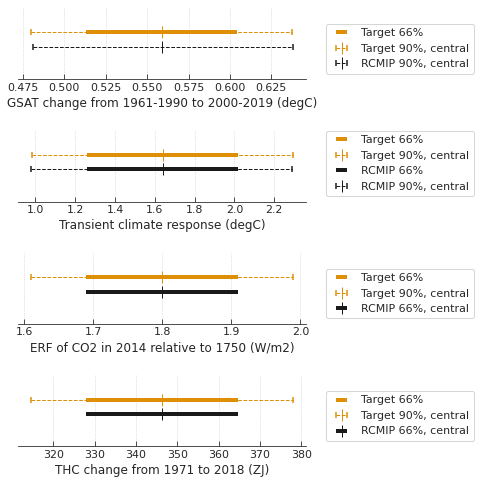

In [19]:
p1 = wrap_plotspace(4, kw_space={'height': 1., 'aspect': 4.})

color_assessed = 'k'
color_assumed = 'C1'
yc = 0.5
yoff = 0.1
ylim = (0., 1.)

for i, vn in enumerate(['tas change', 'tcr', 'erf|CO2', 'thc change']):
    vn_rcmip2 = map_names_rcmip2.get(vn, vn)
    ax = p1.figure.axes[i]
    p1.despine(ax, left=True)

    d1 = (
        assessed_ranges.get(vn_rcmip2).squeeze().dropna()
        * factors_indicator.get(vn_rcmip2, 1)
    )
    y1 = yc - 0.5*yoff
    label = 'RCMIP 90%, central'
    ret = draw_range(
        ax, d1, y1, 'very_likely', 1, color=color_assessed, label=label,
    )
    mark_central = ret is None
    label = 'RCMIP 66%'
    if mark_central:
        label += ', central'
    draw_range(
        ax, d1, y1, 'likely', 4,
        color=color_assessed, label=label, mark_central=mark_central,
    )

    d1 = dict(zip(qnames, rv_indicators[vn].ppf(qlevs)))
    y1 = yc + 0.5*yoff
    draw_range(
        ax, d1, y1+yoff, 'very_likely', 1, color=color_assumed,
        label='Target 90%, central',
    )
    draw_range(
        ax, d1, y1+yoff, 'likely', 4,
        color=color_assumed, label='Target 66%', mark_central=False,
    )

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[::-1], labels[::-1],
        loc='lower left', bbox_to_anchor=(1.05, 0.),
    )

    ax.set_ylim(*ylim)
    ax.grid(axis='x')
    ax.tick_params(
        axis='y', which='both',
        left=False, right=False, labelleft=False,
    )
    ax.set_xlabel(map_labels[vn])

### (1) Constrain CO2 ERF

In [20]:
name = 'erf|CO2'
obj_mh =SamplingMH(dfin.loc[index1a, name], rv_indicators[name].pdf)
index2, index2a = obj_mh.sampling()
print('acceptance rate', len(index2a)/len(index2))

acceptance rate 0.4918061561537602


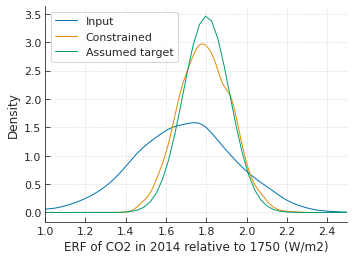

In [21]:
xlim = (1., 2.5)
p1 = wrap_plotspace()
ax = p1.figure.axes[0]
p1.despine(ax)
dfin.loc[index1a, name].iloc[:2000].plot(ax=ax, kind='kde', label='Input')
dfin.loc[index2a, name].iloc[:2000].plot(ax=ax, kind='kde', label='Constrained')
x = np.linspace(*xlim)
ax.plot(x, rv_indicators[name].pdf(x), label='Assumed target')
ax.legend()
ax.set_xlim(*xlim)
ax.set_xlabel(map_labels[name])
ax.grid()

### (2) Constrain transient climate response

In [22]:
name = 'tcr'
obj_mh =SamplingMH(dfin.loc[index2a, name], rv_indicators[name].pdf, w_cutoff=1e2)
index3, index3a = obj_mh.sampling()
print('acceptance rate', len(index3a)/len(index3))

acceptance rate 0.5446773303916161


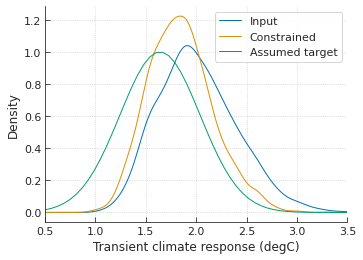

In [23]:
xlim = (0.5, 3.5)
p1 = wrap_plotspace()
ax = p1.figure.axes[0]
p1.despine(ax)
dfin.loc[index2a, name].iloc[:2000].plot(ax=ax, kind='kde', label='Input')
dfin.loc[index3a, name].iloc[:2000].plot(ax=ax, kind='kde', label='Constrained')
x = np.linspace(*xlim)
ax.plot(x, rv_indicators[name].pdf(x), label='Assumed target')
ax.legend()
ax.set_xlim(*xlim)
ax.set_xlabel(map_labels[name])
ax.grid()

### (3) Constrain recent warming trends

Considering that the target distribution is highly localized with respect to the proposed distribution in this particular case, non-diagonal covariance components are assumed to be zero.

In [24]:
names = ['tas change', 'thc change']
mu = np.array([rv_indicators[name].mean() for name in names])
cov = np.diag([rv_indicators[name].var() for name in names])
obj_mh =SamplingMH(dfin.loc[index3a, names], mean=mu, cov=cov)
index4, index4a = obj_mh.sampling()
print('acceptance rate', len(index4a)/len(index4))

acceptance rate 0.04795234549516009


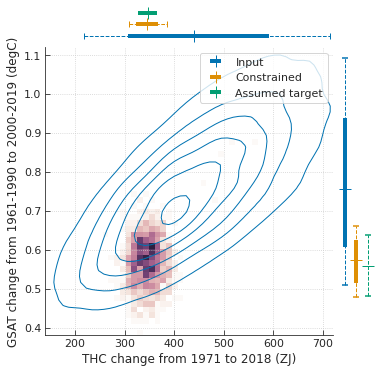

In [25]:
xname = 'thc change'
yname = 'tas change'
xlim = (140., 720.)
ylim = (0.38, 1.12)
pdf = gaussian_kde(dfin.loc[index3a, [xname, yname]].transpose())

p1 = wrap_plotspace(kw_space={'aspect': 1., 'height': 4.})
ax = p1.figure.axes[0]
p1.despine(ax)

z1 = np.linspace(*xlim)
z2 = np.linspace(*ylim)
x, y = np.meshgrid(z1, z2)
z = pdf([x.ravel(), y.ravel()]).reshape(x.shape)
ax.contour(x, y, z, colors=['C0'])
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
ax.hist2d(
    dfin.loc[index4a, xname], dfin.loc[index4a, yname],
    bins=50, density=True, range=[xlim, ylim], cmap=cmap, zorder=0,
)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

def get_position(bnd, apos):
    return bnd[0] + (bnd[1] - bnd[0]) * apos

d1 = dfin.loc[index3a, xname].quantile(qlevs).rename(dict(zip(qlevs, qnames)))
pos = get_position(ylim, 1.04)
draw_range(ax, d1, pos, 'very_likely', 1, color='C0', axis='x', mark_central=False)
draw_range(ax, d1, pos, 'likely', 4, color='C0', axis='x', label='Input')

d1 = dfin.loc[index4a, xname].quantile(qlevs).rename(dict(zip(qlevs, qnames)))
pos = get_position(ylim, 1.08)
draw_range(ax, d1, pos, 'very_likely', 1, color='C1', axis='x', mark_central=False)
draw_range(ax, d1, pos, 'likely', 4, color='C1', axis='x', label='Constrained')

name_rcmip2 = map_names_rcmip2[xname]
d1 = (
    assessed_ranges.get(name_rcmip2).squeeze().dropna()
    * factors_indicator.get(name_rcmip2, 1)
)
pos = get_position(ylim, 1.12)
draw_range(ax, d1, pos, 'likely', 4, color='C2', axis='x', label='Assumed target')
ax.legend()

d1 = dfin.loc[index3a, yname].quantile(qlevs).rename(dict(zip(qlevs, qnames)))
pos = get_position(xlim, 1.04)
draw_range(ax, d1, pos, 'very_likely', 1, color='C0', axis='y')
draw_range(ax, d1, pos, 'likely', 4, color='C0', axis='y', mark_central=False)

d1 = dfin.loc[index4a, yname].quantile(qlevs).rename(dict(zip(qlevs, qnames)))
pos = get_position(xlim, 1.08)
draw_range(ax, d1, pos, 'very_likely', 1, color='C1', axis='y')
draw_range(ax, d1, pos, 'likely', 4, color='C1', axis='y', mark_central=False)

name_rcmip2 = map_names_rcmip2[yname]
d1 = (
    assessed_ranges.get(name_rcmip2).squeeze().dropna()
    * factors_indicator.get(name_rcmip2, 1)
)
pos = get_position(xlim, 1.12)
draw_range(ax, d1, pos, 'very_likely', 1, color='C2', axis='y')

ax.set_xlabel(map_labels[xname])
ax.set_ylabel(map_labels[yname])
ax.grid()

## Comparison between CMIP-consistent and RCMIP2-constrained ensembles

Finally, two set of 600 members are randomly selected from `index1a` and `index4a` for CMIP-consistent (prior) and RCMIP2-constrained (posterior) ensembles, and the followings are the ones adopted in Tsutsui (2021).
The MCE contribution to the RCMIP2 project (Nicholls et al. 2021, https://doi.org/10.1029/2020EF001900) comes from this RCMIP2-constrained ensemble.

In [26]:
members_prior = index1a[1000:1000+600]
members_const = index4a[-600:]

The two ensembles are compared in terms of an extended set of the indicators, including those associated with carbon cycle, climate sensitivity, warming trends, and historical changes in effective radiative forcing (ERF), as displayed in the bottom figure, which is similar to Figure 11 of Tsutsui (2021).

In [27]:
# Gather additional indicator data
for vn, vn_full in [
    ('coct|2x', 'coct__y70__1pctCO2'),
    ('cbst|2x', 'cbst__y70__1pctCO2'),
    ('coct|4x', 'coct__y140__1pctCO2'),
    ('cbst|4x', 'cbst__y140__1pctCO2'),
    ('coct|2011', 'coct__2011@1750__historical_1750'),
    ('cbst|2011', 'cbst__2011@1750__historical_1750'),
    ('ctot|2011', 'ctot__2011@1750__historical_1750'),
    ('tcre', 'tcre__y70__1pctCO2'),
    ('erf|CH4', 'erf_CH4__2011@1750__historical_1750'),
    ('erf|N2O', 'erf_N2O__2011@1750__historical_1750'),
    ('erf|F-Gases', 'erf_F-Gases__2011@1750__historical_1750'),
    ('erf|Montreal Gases', 'erf_Montreal_Gases__2011@1750__historical_1750'),
    ('erf|Aerosols', 'erf_Aerosols__2014@1750__historical_1750'),
    ('erf|O3 Strat', 'erf_Stratospheric_Ozone__2011@1750__historical_1750'),
    ('erf|O3 Trop', 'erf_Tropospheric_Ozone__2011@1750__historical_1750'),
]:
    dfin[vn] = pd.Series(ncf_calib.variables[vn_full][:])
    map_labels[vn] = '{} ({})'.format(
        ncf_calib.variables[vn_full].long_name,
        ncf_calib.variables[vn_full].units,
    )

for vn, vn_full in [
   ('ecs', 'climate__ecs_reg'),
]:
    dfin[vn] = ncf_parms.variables[vn_full][:]
    map_labels[vn] = '{} ({})'.format(
        ncf_parms.variables[vn_full].long_name,
        ncf_parms.variables[vn_full].units,
    )

In [28]:
# Adjust some text for formatting axis labels
map_labels = {
    k:
    v
    .replace('Effective radiative forcing', 'ERF')
    .replace('Transient temperature response to cumulative CO2 emissions', 'TCRE')
    .replace('Transient climate response', 'TCR')
    .replace('Equilibrium climate sensitivity', 'ECS')
    .replace('70th year', '70th year of 1pctCO2')
    .replace('140th year', '140th year of 1pctCO2')
    .replace('W/m^2', 'W/m2')
    for k, v in map_labels.items()
}

In [29]:
# AR5-assessed ranges for comparison
assessed_ranges_ar5 = {
    'ecs': {'likely__lower': 1.5, 'likely__upper': 4.5},
    'tcr': {'likely__lower': 1., 'likely__upper': 2.5},
    'tcre': {'likely__lower': 0.8, 'likely__upper': 2.5},
    'coct|2011': {
        'likely__lower': 125.,
        'central': 155.,
        'likely__upper': 185.,
    },
    'cbst|2011':{
        'likely__lower': 70.,
        'central': 160.,
        'likely__upper': 250.,
    },
    'ctot|2011': {
        'likely__lower': 470.,
        'central': 555.,
        'likely__upper': 640.,
    },
}
names_ar5_assessed = [
    'erf|CH4', 'erf|N2O', 'erf|Montreal Gases',
    'erf|F-Gases', 'erf|O3 Trop', 'erf|O3 Strat',
]

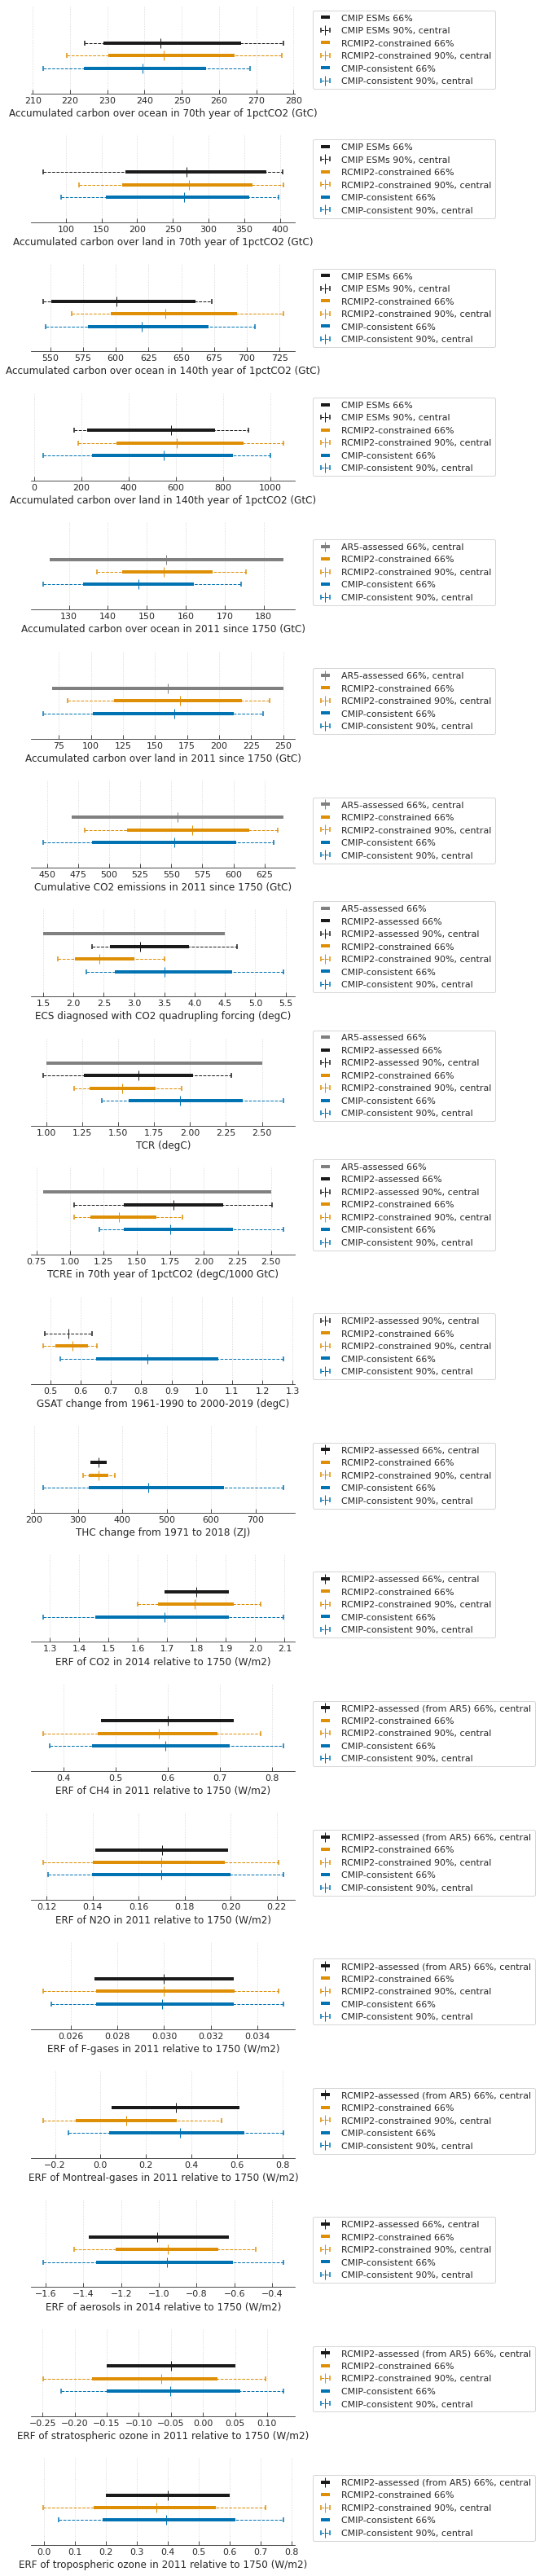

In [30]:
names_plot = [
    'coct|2x', 'cbst|2x', 'coct|4x', 'cbst|4x',
    'coct|2011', 'cbst|2011', 'ctot|2011',
    'ecs', 'tcr', 'tcre', 'tas change', 'thc change',
    'erf|CO2', 'erf|CH4', 'erf|N2O',
    'erf|F-Gases', 'erf|Montreal Gases',
    'erf|Aerosols', 'erf|O3 Strat', 'erf|O3 Trop',
]
map_qlevs = dict(zip(qlevs, qnames))

p1 = wrap_plotspace(len(names_plot), kw_space={'height': 1.5, 'aspect': 3.})

ybase = 0.2
yoff = 0.1
ylim = (0., 0.7)

for i, vn in enumerate(names_plot):
    vn_rcmip2 = map_names_rcmip2.get(vn, vn)
    d_prior = dfin.loc[members_prior, vn].quantile(qlevs).rename(map_qlevs)
    d_const = dfin.loc[members_const, vn].quantile(qlevs).rename(map_qlevs)
    d_rcmip2 = (
        assessed_ranges.get(vn_rcmip2).squeeze().dropna()
        * factors_indicator.get(vn_rcmip2, 1)
    ).to_dict()

    if vn in df_parms_cmip_esm:
        d_cmip_esm = df_parms_cmip_esm[vn].quantile(qlevs).rename(map_qlevs)
        # consider mean value as median
        d_cmip_esm['central'] = df_parms_cmip_esm[vn].mean()
        d_cmip_esm = d_cmip_esm.to_dict()
    else:
        d_cmip_esm = {}
    
    ax = p1.figure.axes[i]
    p1.despine(ax, left=True)

    def wrap_draw_range(d1, color, label_hd):
        mark_central = 'central' in d1
        label = f'{label_hd} 90%'
        if mark_central:
            label += ', central'
        ret = draw_range(
            ax, d1, pos, 'very_likely', 1, color=color, label=label,
            mark_central=mark_central,
        )
        mark_central = ret is None and 'central' in d1
        label = f'{label_hd} 66%'
        if mark_central:
            label += ', central'
        draw_range(
            ax, d1, pos, 'likely', 4, color=color, label=label,
            mark_central=mark_central,
        )

    pos = ybase
    wrap_draw_range(d_prior, 'C0', 'CMIP-consistent')
    pos += yoff
    wrap_draw_range(d_const, 'C1', 'RCMIP2-constrained')
    if d_rcmip2:
        pos += yoff
        label = 'RCMIP2-assessed'
        if vn in  names_ar5_assessed:
            label += ' (from AR5)'
        wrap_draw_range(d_rcmip2, 'k', label)
    if d_cmip_esm:
        pos += yoff
        wrap_draw_range(d_cmip_esm, 'k', 'CMIP ESMs')
    if vn in assessed_ranges_ar5:
        pos += yoff
        wrap_draw_range(assessed_ranges_ar5[vn], '0.5', 'AR5-assessed')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[::-1], labels[::-1],
        loc='lower left', bbox_to_anchor=(1.05, 0.),
    )

    ax.set_ylim(*ylim)
    ax.tick_params(
        axis='y', which='both',
        left=False, right=False, labelleft=False,
    )
    ax.set_xlabel(map_labels[vn])
    ax.grid(axis='x')